# Business Understanding

Apple would like to evaluate public sentiment about its products as compared to its competitor, Google.  Social media is one area in which we can obtain feedback about our products.  The sentiment expressed on social media can spread quickly and influence purchasing decisions for many consumers.  Paying human raters to do this is expensive, especially when dealing with the sheer number of social media posts in existence.  Here, we would like to build a model which can use Tweets to predict the nature of public sentiment about Apple products as compared to those of Google, use our insights to make improvements to our products so that we can positively influence perception of the company and by extension, increase market share and revenue, all in the most cost-effective manner possible.

# Data Understanding

Our dataset of over 9,000 Tweets is sourced from CrowdFlower via data.world.  Humans rated Tweet sentiment as positive, negative, or neither (neutral).  Conducting some surface-level analysis to get oriented.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet, words
import nltk
nltk.download('words', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
np.random.seed(0)
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

stop_words = set(stopwords.words('english'))
english_words = set(words.words())

In [2]:
# define functions used in this notebook
def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def process_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words and word.lower() in english_words]
    return tokens

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag))
                         for token, tag in nltk.pos_tag(tokens)]
    return ' '.join(lemmatized_tokens)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [3]:
# read in the data and get an idea of its size and features
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# look at format of data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Data Preparation

## Data Cleaning

In [5]:
# change the column names to make them more manageable and descriptive
df.columns = ['Tweet', 'Product/Brand', 'Emotion']
df.head()

,Tweet,Product/Brand,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# check for duplicate values (retweets, bots??)
duplicate_rows = df[df.duplicated(subset='Tweet', keep=False)]
print("Duplicate Rows based on 'Tweet' column:")
print(duplicate_rows)

Duplicate Rows based on 'Tweet' column:
                                                  Tweet       Product/Brand  \
7     #SXSW is just starting, #CTIA is around the co...             Android   
9     Counting down the days to #sxsw plus strong Ca...               Apple   
17    I just noticed DST is coming this weekend. How...              iPhone   
20    Need to buy an iPad2 while I'm in Austin at #s...                iPad   
21    Oh. My. God. The #SXSW app for iPad is pure, u...  iPad or iPhone App   
24    Really enjoying the changes in Gowalla 3.0 for...         Android App   
466      Before It Even Begins, Apple Wins #SXSW {link}               Apple   
468      Before It Even Begins, Apple Wins #SXSW {link}               Apple   
774   Google to Launch Major New Social Network Call...                 NaN   
776   Google to Launch Major New Social Network Call...                 NaN   
2230  Marissa Mayer: Google Will Connect the Digital...                 NaN   
2232  Mariss

In [7]:
# drop duplicates
df.drop_duplicates(subset='Tweet', keep='first', inplace=True)

In [8]:
# check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9066 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          9065 non-null   object
 1   Product/Brand  3280 non-null   object
 2   Emotion        9066 non-null   object
dtypes: object(3)
memory usage: 283.3+ KB


In [9]:
# check for null values
missing_values = df.isnull().sum()

print(missing_values)

Tweet               1
Product/Brand    5786
Emotion             0
dtype: int64


In [10]:
# drop null values for 'Tweet'
df = df.dropna(subset=['Tweet'])

In [11]:
# check that null was dropped
null_values = df.isnull().sum()
print(null_values)

Tweet               0
Product/Brand    5785
Emotion             0
dtype: int64


In [12]:
# remove links and non-alphanumeric characters, replace user mentions
df['clean_Tweet'] = df['Tweet'].apply(clean_tweet_text)

df['clean_Tweet'][0]

' i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw'

# Exploratory Data Analysis

In [13]:
# check values and their distributions for Product/Brand

df['Product/Brand'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: Product/Brand, dtype: int64

In [14]:
# check values and their distributons for Emotion

df['Emotion'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: Emotion, dtype: int64

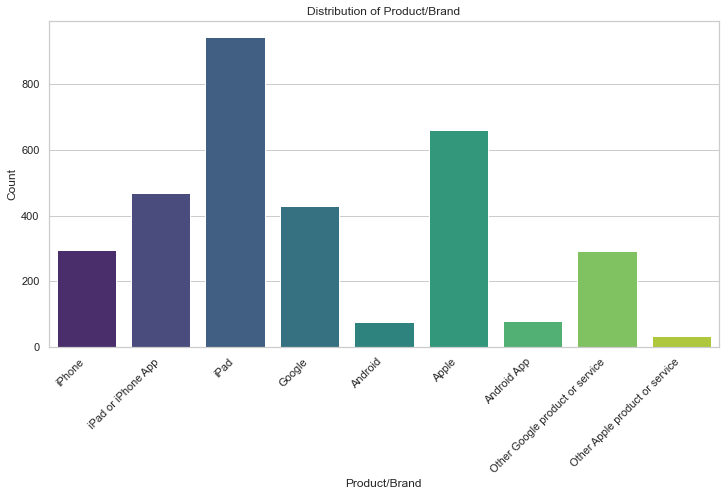

In [15]:
# visualize these distributions
emotion_distribution = df['Product/Brand'].value_counts()

# set the style of seaborn
sns.set(style="whitegrid")

# create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Product/Brand', data=df, palette="viridis")

# add labels and title
plt.title('Distribution of Product/Brand')
plt.xlabel('Product/Brand')
plt.ylabel('Count')

# rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.savefig('Product.png', dpi=300, bbox_inches='tight')

# show the plot and save
plt.show()

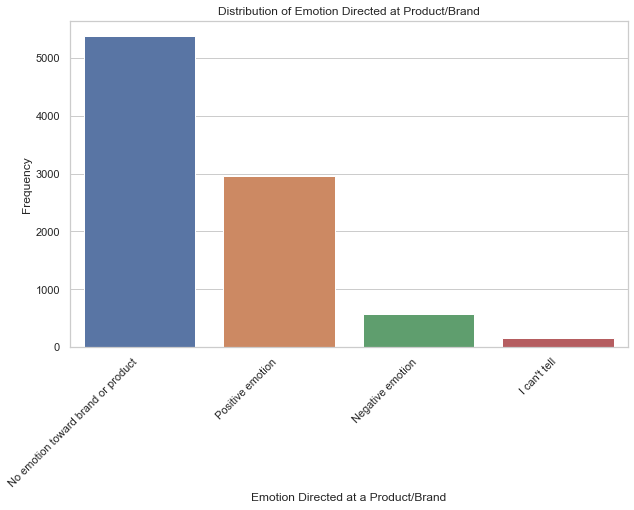

In [16]:
#Visualize distributions of emotions
emotion_distribution = df['Emotion'].value_counts()

# Bar chart for 'Emotion'
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_distribution.index, y=emotion_distribution.values, palette='deep')
plt.title('Distribution of Emotion Directed at Product/Brand')
plt.xlabel('Emotion Directed at a Product/Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
# combine 'neutral' and 'I can't tell' as both being neutral sentiment
df['Emotion'] = df['Emotion'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

print (df['Emotion'].value_counts())

Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: Emotion, dtype: int64


In [18]:
# combine negative and neutral emotions as being non-positive so that we cna build a binary classifier
df['Emotion'] = df['Emotion'].replace({
    "Neutral emotion": 'Not Positive',
    'Negative emotion': 'Not Positive'
})

print (df['Emotion'].value_counts())

Not Positive        6097
Positive emotion    2968
Name: Emotion, dtype: int64


In [19]:
# simplify by defining different Product/Brand values as either Apple or Google

df['Brand'] = df['Product/Brand'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

print(df['Brand'].value_counts())

Apple     2402
Google     585
Name: Brand, dtype: int64


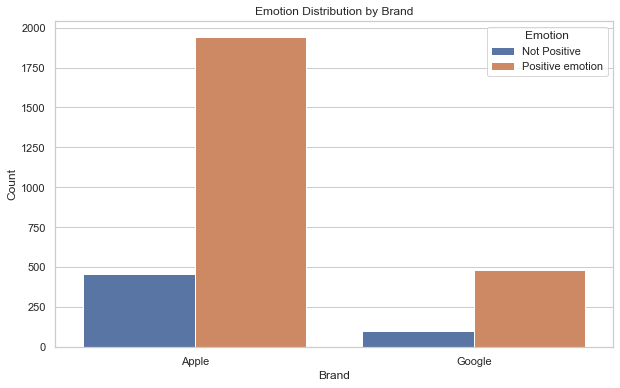

In [20]:
# plot Emotion distribution by brand
plt.figure(figsize=(10,6))
sns.countplot(x='Brand', hue='Emotion', data=df)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# separate the data into Positive and Not Positive subsets
positive_tweets = df[df['Emotion'] == 'Positive emotion']['clean_Tweet']
not_positive_tweets = df[df['Emotion'] == 'Not Positive']['clean_Tweet']

# process the text for each category
positive_tokens = positive_tweets.apply(process_text)
not_positive_tokens = not_positive_tweets.apply(process_text)

# convert token lists to sets for positive and not positive categories
unique_positive_tokens = set([token for sublist in positive_tokens for token in sublist])
unique_not_positive_tokens = set([token for sublist in not_positive_tokens for token in sublist])

# remove words that appear in both categories
unique_positive_words = unique_positive_tokens - (unique_not_positive_tokens)
unique_not_positive_words = unique_not_positive_tokens - (unique_positive_tokens)

print("\nUnique Positive Words:")
print(list(unique_positive_words)[:20])

print("\nUnique Not Positive Words:")
print(list(unique_not_positive_words)[:20])


Unique Positive Words:
['upside', 'wonderful', 'settle', 'organized', 'jammy', 'expectation', 'journal', 'outlandish', 'awesomeness', 'fusion', 'bin', 'underestimate', 'keg', 'flask', 'knockout', 'storage', 'pair', 'twice', 'mater', 'copper']

Unique Not Positive Words:
['crash', 'boil', 'animated', 'indexing', 'minimize', 'landed', 'lesson', 'unlike', 'ability', 'umbrella', 'copyright', 'begun', 'ware', 'dime', 'jenny', 'bulletproof', 'landscape', 'handset', 'traveled', 'loosing']


This doesn't seem that useful!  Let's look at the most frequently occuring words.

In [22]:
# flatten the list of tokens for each category
positive_tokens_flat = [token for sublist in positive_tokens for token in sublist]
not_positive_tokens_flat = [token for sublist in not_positive_tokens for token in sublist]

In [23]:
fdist_positive = FreqDist(positive_tokens_flat)
fdist_not_positive = FreqDist(not_positive_tokens_flat)

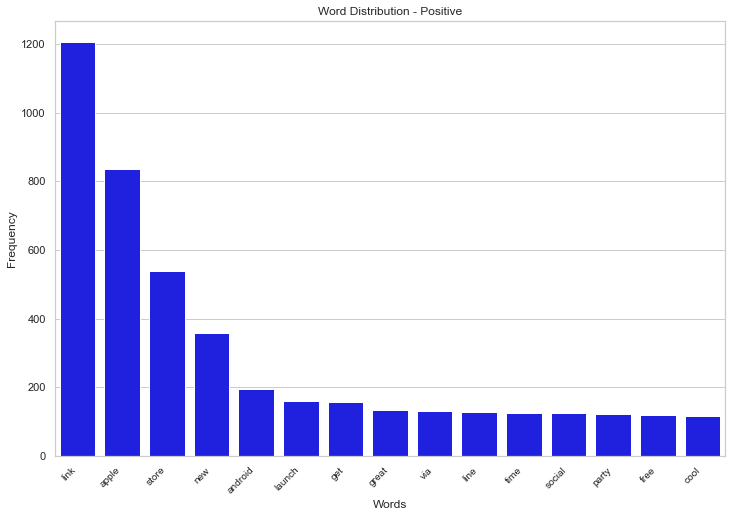

In [24]:
def plot_word_distribution(fdist, label, color):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=[word[0] for word in fdist.most_common(15)],
                y=[freq[1] for freq in fdist.most_common(15)],
                color=color)
    plt.title(f"Word Distribution - {label}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.savefig('words.png', dpi=300, bbox_inches='tight')
    plt.show()

# Set the style for the plot
sns.set(style="whitegrid")
sns.set_palette("bright")

# Plot word distribution for each category
plot_word_distribution(fdist_positive, "Positive", 'blue')

## Data Preprocessing

In [25]:
# view 'Emotion' distribution
df['Emotion'].value_counts()

Not Positive        6097
Positive emotion    2968
Name: Emotion, dtype: int64

In [26]:
# view 'Product/Brand' distribution
df['Product/Brand'].value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: Product/Brand, dtype: int64

In [27]:
# view 'Brand' distribution
print(df['Brand'].value_counts())

Apple     2402
Google     585
Name: Brand, dtype: int64


In [28]:
# view data types in 'Brand'
df['Brand'].apply(type).value_counts()

<class 'float'>    6078
<class 'str'>      2987
Name: Brand, dtype: int64

In [29]:
# replace null values with 'unknown' prior to encoding
df['Brand'].fillna('unknown', inplace=True)
df['Product/Brand'].fillna('unknown', inplace=True)

In [30]:
enc = LabelEncoder()

# fit and transform the specified columns in the DataFrame
df['Emotion'] = enc.fit_transform(df['Emotion'])
df['Brand'] = enc.fit_transform(df['Brand'])
df['Product/Brand'] = enc.fit_transform(df['Product/Brand'])

print(df['Brand'].value_counts())
print(df['Emotion'].value_counts())

NameError: name 'LabelEncoder' is not defined

In [ ]:
# load the stop words
stop_words = set(stopwords.words('english'))

df['clean_Tweet'] = df['clean_Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df.head()

In [ ]:
# load the stop words and English words set
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

df['clean_Tweet'] = df['clean_Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words and word.lower() in english_words]))

df.head()

In [ ]:
# lematize words
df['clean_Tweet'] = df['clean_Tweet'].apply(lemmatize_sentence)

# remove one-word sentences
df['clean_Tweet'] = df['clean_Tweet'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

# display the cleaned column
df['clean_Tweet'].head()

In [ ]:
df.info()

# Modeling and Evaluation

In [ ]:
# split data into train and test
X = df.drop(['Tweet', 'Emotion'], axis=1)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# vectorize
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_Tweet'])
X_test_vec = vectorizer.transform(X_test['clean_Tweet'])

In [ ]:
sampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

In [ ]:
# initialize the model
classifier = BernoulliNB()

In [ ]:
# fit the model
classifier.fit(X_train_vec, y_train)

In [ ]:
# predict
preds = classifier.predict(X_test_vec)

In [ ]:
# evaluate
accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

This model is okay but really does not perform well predicting class 1.  Even the F1-score accounting for the class imbalance isn't great.  Let's try something else, like a logistic regression.

In [ ]:
df.info()

In [ ]:
# define X and y
X = df.drop(['Tweet', 'Emotion'], axis=1)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_Tweet'])
X_test_vec = vectorizer.transform(X_test['clean_Tweet'])

In [ ]:
# initialize logistic regression model
logreg_model = LogisticRegression()

# fit the model using cross-validation
cross_val_scores = cross_val_score(logreg_model, X_train_vec, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cross_val_scores)

# fit the model on the training data
logreg_model.fit(X_train_vec, y_train)

y_pred = logreg_model.predict(X_test_vec)

# evaluate the model on the test data
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [ ]:
#display confusion matrix
sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# plot CV result
results_df = pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# separate features and target variable, drop irrelevant columns
X = df.drop(['Tweet', 'Emotion'], axis=1)
y = df['Emotion']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_Tweet'])
X_test_vec = vectorizer.transform(X_test['clean_Tweet'])

# initialize Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# train model on the training data
random_forest_model.fit(X_train_vec, y_train)

# predict
y_pred = random_forest_model.predict(X_test_vec)

# evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# print results
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

In [ ]:
# plot confusion martix for visualization
cm = confusion_matrix(y_test, y_pred)
class_names = ['Majority Class (0)', 'Minority Class (1)']

plt.figure(figsize=(9, 7))
sns.set_style("white")


cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                 xticklabels=class_names, yticklabels=class_names,
                 cbar_kws={'label': 'Count', 'shrink': 0.8, 'format': '%.0f'},
                 square=True, linewidths=1.5, linecolor='gray', 
                 annot_kws={'size': 14, 'weight': 'bold'})

# add labels and title
ax.set_title('Confusion Matrix: Random Forest Model', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')

# show and save
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# print metrics
print(classification_report(y_test, y_pred, target_names=class_names))

We will use precision as our metric to evaluate since preventing false positives is more important than false negatives (we want to catch the most negative sentiment we can... while unnecessarily spending some extra money to target false negatives is not ideal, it is more important to be aware of true negative sentiment).  We can see the Random Forest model correctly predicts sentiment 71% of the time as evaluated by precison.
The precision score for predicting class 1 using this model is improved.

# Conclusions

The Random Forst model demonstrates the best performace with a weighted average precision score of .71, correctly predicting Tweet sentiment 71% of the time.

## Limitations

1) The limited amount of data is not ideal for modeling and additional data collection, particularly for the minority class, is warranted to improve the model.

2) Selection bias - Twitter data only may not be representative of overall sentiment since a small portion of the consumer market actually tweets.  Data collection from other social media platforms and/or consumer surveys might be more informative.

## Recommendations

1) Deploy a Random Forest model to predict Tweet sentiment rather than paying raters to rate Tweets, giving the company the ability to evaluate public perception in a more cost-effective manner.

2) Collect more data, particularly from the minority class in order to improve the model.

3) Evaluate public excitement regarding Android versus our competitor product.

## Next Steps

1) Additional data collection

2) Monitoring and validating new data on a continual basis is essential, to ensure the model is refined when needed to maintain its efficacy.